In [154]:
import matplotlib.pyplot as plt
%matplotlib inline

import random as r
from math import sqrt, cos, sin

from anytree import Node, RenderTree

b=[r.uniform(1,7) for i in range(5)]
unclassified_points=[]

for rad in b:
    a=[r.uniform(0,6.2831853072) for i in range(100)]
    unclassified_points=unclassified_points+[[rad*cos(3*c),rad*sin(2*c)] for c in a]

"""
    The below line generates 3d data, which can also be handled by the implementations
    (though plotting doesn't work)
"""        
#unclassified_points=[[r.uniform(-5,5),r.triangular(-5,5, 0), r.uniform(-5,5)] for i in range(200)]

"\n    The below line generates 3d data, which can also be handled by the implementations\n    (though plotting doesn't work)\n"

# k-Means Implementation

In [155]:
class kMeans:
    def __init__(self, points, num_centroids):
        self.points=points
        self.num_centroids=num_centroids
        self.colors=[[[r.random() for i in range(3)]] for j in range(num_centroids)]
        #Nodes selected randomly from points
        self.centroids=[self.points[i] for i in r.sample(range(len(self.points)), num_centroids)]
        self.groups=[]
        
    def metric(self,a,b):
        """
            Standard L2 metric function
        """
        return(sqrt(sum([(i-j)**2 for i,j in zip(a,b)])))
    
    def find_centroid(self,point):
        """
            Finds nearest centroid
        """
        dist=[self.metric(point, centroid) for centroid in self.centroids]
        return(dist.index(min(dist)))
    
    def centroid_update(self, group):
        """
            Returns centroid of group
        """
        N=len(group)
        group_sum=[sum(coordinate) for coordinate in zip(*group)]
        return([coordinate/N for coordinate in group_sum])
    
    def fit_group_update(self):
        """
            Add all points to groups and then updates centroids
        """
        groups=[[] for i in range(self.num_centroids)]
        
        for point in self.points:
            groups[self.find_centroid(point)].append(point)
            
        new_centroids=[self.centroid_update(group) for group in groups]
        
        self.centroids=new_centroids
        self.groups=groups
        
    def fit_groups(self, times=10):
        """
            Just runs fit_group_update some number of times and then adds points
            to nearest centroid one final time
        """
        for i in range(times):
            self.fit_group_update()
            
        groups=[[] for i in range(self.num_centroids)]
        
        for point in self.points:
            groups[self.find_centroid(point)].append(point)
            
        self.groups=groups
            
    def color_update(self):
        """
            Changes colors
        """
        self.colors=[[[r.random() for i in range(3)]] for j in range(self.num_centroids)]
        
    def plot_points(self):
        """
            Plots all points
        """
        fig, ax = plt.subplots()
        plt.scatter(*zip(*self.points))
        ax.set_aspect(1) 
            
    def plot_groups(self):
        """
            Plots all groups and centroids
        """
        if self.groups:
            fig, ax = plt.subplots()
            ax.set_aspect(1)

            for group, centroid, num in zip(self.groups, self.centroids, range(self.num_centroids)):
                plt.scatter(*zip(*group), c=self.colors[num])
                plt.scatter(*centroid, c=self.colors[num], s=120, edgecolors='black')
        else:
            self.fit_groups()
            self.plot_groups()

In [156]:
kMeans_cluster=kMeans(unclassified_points,5)

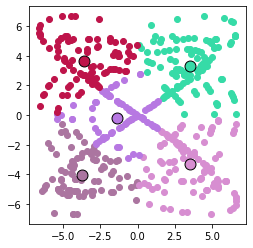

In [157]:
kMeans_cluster.plot_groups()

# DBSCAN Implementation

In [158]:
class DBSCAN:
    def __init__(self, points, min_neighbors, max_dist):
        self.points=points
        self.min_neighbors=min_neighbors
        self.max_dist=max_dist
        self.groups=[]
        self.noise=[]
        self.colors=[]
        
    def metric(self,a,b):
        """
            Standard L2 metric function
        """
        return(sqrt(sum([(i-j)**2 for i,j in zip(a,b)])))
    
    def find_neighbors(self, point):
        """
            Returns a list of all neighboring points if there are at least min_neighbor many of them
        """
        #Find all close by neighbors
        neighbors_dist=[self.metric(point, neighbor)<=self.max_dist for neighbor in self.points]
        
        #Return close neighbors if there is enough of them
        if sum(neighbors_dist)>=self.min_neighbors:
            return([point for point, dist in zip(self.points, neighbors_dist) if dist])
        else:
            return()
        
    def find_group(self, center):
        """
            Finds group centered at center
        """
        group=[]
        #Check if a new group is actually going to be made
        if not self.find_neighbors(center):
            return()

        #List of points which have been added by a neighbor
        temp_group=[center]

        while temp_group:
            #Pop and add point in temp_group to actual group
            current_center=temp_group.pop(0)
            group.append(current_center)

            #Find neighbors of current point of interest
            neighbors=self.find_neighbors(current_center)
            
            #Add new things to temp_group to continue the chain
            for neighbor in neighbors:
                if neighbor not in group+temp_group:
                    temp_group.append(neighbor)
                    
        return(group)
    
    def fit_groups(self):
        """
            Fits groups to data and identifies noise
        """
        groups=[]
        unclassified_points=self.points.copy()
        noise=[]
        
        while unclassified_points:
            #Get current first unclassified point
            current_center=unclassified_points.pop(0)
            
            #Find group around point
            current_group=self.find_group(current_center)
            
            #If group is non-empty, add to groups and remove points from unclassified points
            if current_group: 
                for point in current_group:
                    if point in unclassified_points:
                        unclassified_points.remove(point)
    
                groups.append(current_group)
            
            #Else add to noise
            else:
                noise.append(current_center)
                
        if groups:        
            self.groups, self.noise=[groups, noise]
        else:
            raise NameError('No groups were found with current hyperparameters\n Try changing them')
        
        
    def color_update(self):
        """
            Updates colors
        """
        self.colors=[[[r.random() for i in range(3)]] for j in range(len(self.groups))]
    
    def plot_points(self, point=False):
        """
            Plots all points
        """
        fig, ax = plt.subplots()
        plt.scatter(*zip(*self.points))
        ax.set_aspect(1)
        if point:
            ax.add_artist(plt.Circle(point, self.max_dist, fill=False)) 
        
    def plot_group(self, center, circles=False):
        """
            Plots group centered at center, optionally with circles around points
        """
        group=self.find_group(center)
        noise=[point for point in self.points if point not in group]
        
        fig, ax = plt.subplots()
        plt.scatter(*zip(*noise), color='grey')
        plt.scatter(*zip(*group), color='blue')
        ax.set_aspect(1)
        
        if circles:
            for i in group:
                ax.add_artist(plt.Circle(i, self.max_dist, fill=False, color='blue'))       
    
    def plot_groups(self, circles=False):
        """
            Plots all groups, optionally with circles around points
        """
        #Checks if self.fit_groups() has been run or not
        if self.groups:
            if self.colors:
                fig, ax = plt.subplots()
                ax.set_aspect(1)

                if self.noise:
                    plt.scatter(*zip(*self.noise), color='grey', label="Noise")
                    plt.legend()

                for i in range(len(self.groups)):
                    plt.scatter(*zip(*self.groups[i]), c=self.colors[i])
                    if circles:
                        for point in self.groups[i]:
                            ax.add_artist(plt.Circle(point, self.max_dist, 
                                            fill=False, color=self.colors[i][0]))
            else:
                self.color_update()
                self.plot_groups(circles=circles)
        else:
            #Runs self.fit_groups() in case needed
            self.fit_groups()
            self.plot_groups(circles=circles)

In [159]:
DBSCAN_cluster=DBSCAN(unclassified_points,4,0.5)

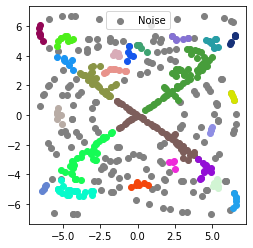

In [160]:
DBSCAN_cluster.plot_groups()

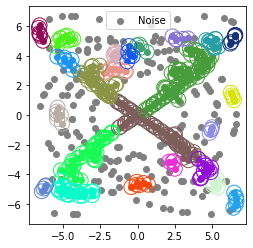

In [161]:
DBSCAN_cluster.plot_groups(circles=True)

# Hierarchical Clustering Implementation

In [162]:
#Make a smaller data set here because otherwise the hierarchical clustering is really slow and not nice to look at
unclassified_points=[[r.uniform(-4, 4), r.triangular(-4, 0, 4)] for i in range(50)]

In [163]:
class HClustering:
    def __init__(self, points):
        """
            self.points is just a list of all of the points
            
            self.unclassified is a dynamic list of all the points (i.e. it is changed
            when we add and remove points in the process of making the hierarchy), and 
            includes also the level in the hierarchy that points are at
            
            self.tree is a list of all points, their parents, and the level
        """
        self.points=points
        self.unclassified=[[point, 0] for point in points]
        self.tree=[[point, None, None, 0] for point in points]
        self.visual_tree=None
        self.colors=[]
        
    def metric(self,a,b):
        """
            Standard L2 metric function
        """
        return(sqrt(sum([(i-j)**2 for i,j in zip(a,b)])))
    
    def midpoint(self, a, b):
        """
            Finds midpoint of two points and returns the new level of the midpoint
        """
        level=max(a[1], b[1])+1
        
        return([[(coordinate_a+coordinate_b)/2 for coordinate_a, coordinate_b in zip(a[0], b[0])], level])
    
    def find_closest(self,center, points):
        """
            Finds point closest to center
        """
        distances=[self.metric(center,point) for point in points]
        min_dist=min(distances)
        return(([center, points[distances.index(min_dist)]], min_dist))
    
    def find_closest_points(self):
        """
            Finds closest two points
        """
        close_points=[]
        points=list(zip(*self.unclassified))[0]
        for i in range(len(points)-1):
            point=points[i]
            reduced_points=points[i+1:]
            close_points.append(self.find_closest(point, reduced_points))
        
        distances=list(zip(*close_points))[1]
        index=distances.index(min(distances))
        
        closest_points=close_points[index][0]
        point_a, point_b=[self.unclassified[points.index(point)] for point in closest_points]
        
        return([point_a, point_b])
    
    def points_update(self):
        """
            Updates self.unclassified by adding new midpoint and deleting two parents
        """
        point_a, point_b =self.find_closest_points()
        
        new_point=self.midpoint(point_a, point_b)
        
        self.unclassified.remove(point_a)
        self.unclassified.remove(point_b)
        self.unclassified.append(new_point)
        
        return([new_point, point_a, point_b])
        
    def tree_update(self):
        """
            Updates self.tree by adding new [point, parent_a, parent_b, level] list
        """
        a=self.points_update()
        level=a[0][1]
        
        point, parent_a, parent_b=list(zip(*a))[0]
        self.tree.append([point, parent_a, parent_b, level])
        
        
    def fit_tree(self):
        """
            Runs self.tree_update until there there is only one point
        """
        while len(self.unclassified)>1:
            self.tree_update()
            
    def plot_points(self):
        """
            Plots all underlying points
        """
        fig, ax = plt.subplots()
        plt.scatter(*zip(*self.points))
        ax.set_aspect(1) 
        
    def color_update(self):
        """
            Updates colors
        """
        levels=list(zip(*self.tree))[3]
        self.colors=[[[r.random() for i in range(3)]] for j in range(max(levels)+1)]
        
    def plot_tree(self, lines=False):
        """
            Plots all points (including new ones introduced by hierarchy)
            
            Point size and color correspond to level in hierarchy
            
            If lines=True, will also plot lines connecting each point to its parents
            (technically just connects the parents, but since new points are midpoints,
            they lie on the connecting lines anyway)
        """
        if len(self.tree)!=len(self.points):
            if self.colors:
                fig, ax = plt.subplots()
                ax.set_aspect(1)

                for point in self.tree:
                    center=point[0]
                    level=point[3]
                    plt.scatter(*center, c=self.colors[level], s=10+50*level)
                    if lines:
                        parent_a, parent_b=point[1:3]
                        if parent_a and parent_b:
                            plt.plot(*zip(parent_a, parent_b), c=self.colors[level][0])
            else:
                self.color_update()
                self.plot_tree(lines=lines)
        else:
            #Runs self.fit_tree() in case needed
            self.fit_tree()
            self.plot_tree(lines=lines)
            
    def make_tree(self):
        if self.tree:
            reversed_tree=self.tree.copy()
            reversed_tree.reverse()
            
            tree_nodes=[[Node(reversed_tree[0][0]), reversed_tree[0][0]]]
              
            for point in reversed_tree:
                child_a, child_b=point[1:3]
                if child_a and child_b:
                    node_index=list(zip(*tree_nodes))[1].index(point[0])
                
                    node_a=Node(child_a, parent=tree_nodes[node_index][0])
                    node_b=Node(child_b, parent=tree_nodes[node_index][0])
                
                    tree_nodes.append([node_a, child_a])
                    tree_nodes.append([node_b, child_b])
                
            self.visual_tree=RenderTree(tree_nodes[0][0])
        else:
            self.fit_tree()
            self.make_tree()
            
    def disp_tree(self):
        if self.visual_tree:
            for pre, _, node in self.visual_tree:
                print("%s%s" % (pre, node.name))
        else:
            self.make_tree()
            self.disp_tree()

In [164]:
HClustering_cluster=HClustering(unclassified_points)

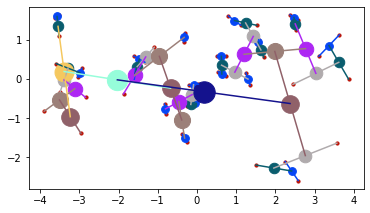

In [165]:
HClustering_cluster.plot_tree(lines=True)

In [166]:
HClustering_cluster.disp_tree()

[0.17278491418453035, -0.32976112670242996]
├── [-2.030766019413404, -0.027753227032947636]
│   ├── [-0.6730280377290094, -0.23977681675548684]
│   │   ├── [-0.38820598285880015, -1.0504412743847085]
│   │   │   ├── [-0.3144467322853268, -1.5145812157314786]
│   │   │   │   ├── [-0.2544092570452756, -1.61056753302626]
│   │   │   │   └── [-0.37448420752537803, -1.4185948984366972]
│   │   │   └── [-0.4619652334322734, -0.5863013330379385]
│   │   │       ├── [-0.8028864333030343, -0.7684074652746791]
│   │   │       │   ├── [-0.8256931363923892, -0.641518498382152]
│   │   │       │   └── [-0.7800797302136795, -0.8952964321672061]
│   │   │       └── [-0.1210440335615125, -0.404195200801198]
│   │   │           ├── [-0.15619481912371458, -0.6557074909399747]
│   │   │           │   ├── [-0.25448933500250703, -0.704737948129361]
│   │   │           │   └── [-0.057900303244922124, -0.6066770337505885]
│   │   │           │       ├── [-0.02455925614039156, -0.5911414530007608]
│   │   │  